## Create and Process Data for modelling

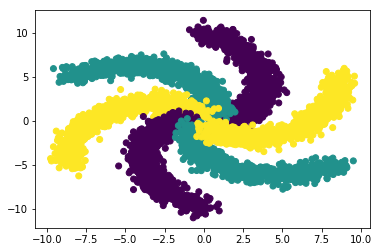

In [3]:
import numpy as np
import matplotlib.pyplot as plt
def get_spiral():
    # Idea: radius -> low...high
    #           (don't start at 0, otherwise points will be "mushed" at origin)
    #       angle = low...high proportional to radius
    #               [0, 2pi/6, 4pi/6, ..., 10pi/6] --> [pi/2, pi/3 + pi/2, ..., ]
    # x = rcos(theta), y = rsin(theta) as usual

    radius = np.linspace(1, 10, 1000)
    thetas = np.empty((6, 1000))
    for i in range(6):
        start_angle = np.pi*i / 3.0
        end_angle = start_angle + np.pi / 2
        points = np.linspace(start_angle, end_angle, 1000)
        thetas[i] = points

    # convert into cartesian coordinates
    x1 = np.empty((6, 1000))
    x2 = np.empty((6, 1000))
    for i in range(6):
        x1[i] = radius * np.cos(thetas[i])
        x2[i] = radius * np.sin(thetas[i])

    # inputs
    X = np.empty((6000, 2))
    X[:,0] = x1.flatten()
    X[:,1] = x2.flatten()

    # add noise
    X += np.random.randn(6000, 2)*0.5

    # targets
    Y = np.array([0]*1000 + [1]*1000 + [2]*1000 + [0]*1000 + [1]*1000 + [2]*1000)
    return X, Y

X,y=get_spiral()

plt.scatter(X[:,0],X[:,1],c=y)
plt.show()

In [4]:
def one_hot_encoder(X):
    N=X.shape[0]
    K=len(np.unique(X))
    Z=np.zeros((N,K))
    for i in range(N):
        c=X[i]
        Z[i,c]=1
    return Z
y_i=one_hot_encoder(y)

In [35]:
def standardize(X):
    stds=X.std(axis=0)
    means=X.mean(axis=0)
    X=(X-means)/stds
    return X,means,stds

In [36]:
X_s,m,s=standardize(X)

In [37]:
X_s

array([[ 0.14994163, -0.00342972],
       [ 0.32618895, -0.03968793],
       [ 0.21991849,  0.14066828],
       ...,
       [ 1.96345965,  0.80340436],
       [ 1.94535723,  1.05012761],
       [ 2.10595064,  1.30413304]])

In [18]:
def train_test_split(X,y,size=0.8,rs=None):
    N=len(X)
    np.random.seed(rs)
    tr_i=np.random.choice(N,int(size*N),replace=False)
    t_i=[i for i in range(N) if i not in tr_i]
    X_train=X[tr_i]
    y_train=y[tr_i]
    X_test=X[t_i]
    y_test=y[t_i]
    return X_train,y_train,X_test,y_test

In [91]:
X_train,y_train,X_test,y_test=train_test_split(X_s,y,size=0.9,rs=20)

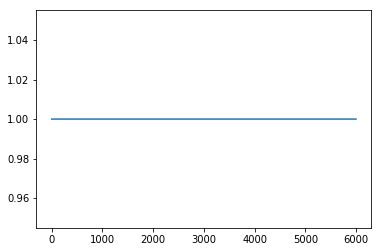

In [59]:
plt.plot(y_i[np.arange(y.shape[0]), y])

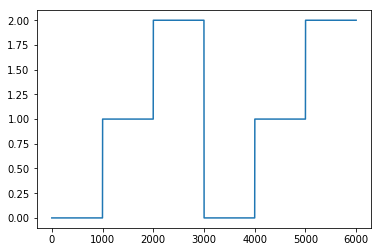

In [60]:
plt.plot(y)

In [61]:
y_i.shape

(6000, 3)

In [80]:
-np.log(y_i[995:1005,y[1000:1010]]).mean()

inf

## Create ANN

In [62]:
import theano
from theano import tensor as T

In [63]:
class HiddenLayer(object):
    def __init__(self,M1,M2,i):
        self.id=i
        self.M1=M1
        self.M2=M2
        W=np.random.randn(M1,M2)/np.sqrt(M1)
        b=np.random.randn(M2)
        self.W=theano.shared(W,name='W{0}'.format(i))
        self.b=theano.shared(b,name='b{0}'.format(i))
        self.params=[self.W,self.b]
    def forward(self,X,activation='relu'):
        if activation=='tanh':
            return T.tanh(X.dot(self.W)+self.b)
        elif activation=='sigmoid':
            return T.nnet.sigmoid(X.dot(self.W)+self.b)
        else:
            return T.nnet.relu(X.dot(self.W)+self.b)
    

In [120]:
class ANN(object):
    def __init__(self,hidden_layer_size):
        self.hidden_layer_size=hidden_layer_size
    def forward(self,X):
        z=X
        for h in self.hidden_layers:
            z=h.forward(z)
        return T.nnet.softmax(z.dot(self.W)+self.b)
    def predict(self,X):
        p=self.forward(X)
        return T.argmax(p,axis=1)
    def fit(self,X,y,lr=0.001,epochs=1000,show_fig=True):
        X_t,y_t,X_v,y_v=train_test_split(X,y,size=0.9,rs=100)
        c_t=[]
        c_v=[]
        cl_t=[]
        cl_v=[]
        N,D=X_t.shape
        self.hidden_layers=[]
        M1=D
        cnt=0
        for M2 in self.hidden_layer_size:
            h=HiddenLayer(M1,M2,cnt)
            self.hidden_layers.append(h)
            M1=M2
            cnt+=1
        M2=len(set(y_t))
        W=np.random.randn(M1,M2)/np.sqrt(M1)
        b=np.random.randn(M2)
        self.W=theano.shared(W,name='W_f')
        self.b=theano.shared(b,name='b_f')
        self.params=[self.W,self.b]
        for h in self.hidden_layers:
            self.params+=h.params
        thX=T.matrix('X')
        thY=T.ivector('y')
        y_p=self.forward(thX)
        cost=-T.mean(T.log(y_p[T.arange(thY.shape[0]),thY]))
        preds=self.predict(thX)
        cost_preds=theano.function(inputs=[thX,thY],outputs=[cost,preds])
        updates=[(p,(p-lr*T.grad(cost,p)) )for p in self.params]
        train=theano.function([thX,thY],updates=updates)
        for i in range(epochs):
            c,p=cost_preds(X_v,y_v)
            c_v.append(c)
            cl_v.append(np.mean(p==y_v))
            c,p=cost_preds(X_t,y_t)
            c_t.append(c)
            cl_t.append(np.mean(p==y_t))
            train(X_t,y_t)
            if i %100==0:
                print('Epoch {0} Train C: {1} Cl: {2} Test C: {3} Cl:{4}'.format(i,c_t[i],cl_t[i],c_v[i],cl_v[i]))
#                 print('Epoch {0} Train C: {1} Test C: {2}'.format(i,c_t[i],c_v[i]))

            
        
        

In [124]:
ann=ANN((5,10,20,5,60,7,10))

In [132]:
ann.fit(X_train,y_train,lr=0.01,epochs=10000)

Epoch 0 Train C: 1.167545616447613 Cl: 0.3347736625514403 Test C: 1.1793505343792476 Cl:0.3148148148148148
Epoch 100 Train C: 1.0935982262773984 Cl: 0.27037037037037037 Test C: 1.0944363849560776 Cl:0.25
Epoch 200 Train C: 1.0889332629108741 Cl: 0.3668724279835391 Test C: 1.0890239101827235 Cl:0.35555555555555557
Epoch 300 Train C: 1.0831292810460846 Cl: 0.404320987654321 Test C: 1.0826685693402593 Cl:0.40370370370370373
Epoch 400 Train C: 1.0754576355657741 Cl: 0.4261316872427984 Test C: 1.074427292808369 Cl:0.4388888888888889
Epoch 500 Train C: 1.065493741571889 Cl: 0.45596707818930043 Test C: 1.0636493619540908 Cl:0.45555555555555555
Epoch 600 Train C: 1.0510348896584933 Cl: 0.4773662551440329 Test C: 1.0477896112264387 Cl:0.46296296296296297
Epoch 700 Train C: 1.0317337120740382 Cl: 0.4882716049382716 Test C: 1.0267930098980205 Cl:0.49074074074074076
Epoch 800 Train C: 1.0060323088512535 Cl: 0.5059670781893004 Test C: 0.9988091684336359 Cl:0.5148148148148148
Epoch 900 Train C: 0.97

Epoch 7500 Train C: 0.06666469941325429 Cl: 0.9755144032921811 Test C: 0.08223612477069975 Cl:0.9685185185185186
Epoch 7600 Train C: 0.06627565887237916 Cl: 0.9757201646090535 Test C: 0.08173453032107555 Cl:0.9666666666666667
Epoch 7700 Train C: 0.06637996891549404 Cl: 0.9761316872427983 Test C: 0.08119015998833548 Cl:0.9666666666666667
Epoch 7800 Train C: 0.06634727670722565 Cl: 0.9765432098765432 Test C: 0.08064142337813622 Cl:0.9685185185185186
Epoch 7900 Train C: 0.06588894029939182 Cl: 0.9767489711934156 Test C: 0.08026031198649931 Cl:0.9666666666666667
Epoch 8000 Train C: 0.0650881868084376 Cl: 0.9761316872427983 Test C: 0.08015906449249113 Cl:0.9666666666666667
Epoch 8100 Train C: 0.06449826271592231 Cl: 0.975925925925926 Test C: 0.08009054331030654 Cl:0.9666666666666667
Epoch 8200 Train C: 0.06415375875515986 Cl: 0.9757201646090535 Test C: 0.07996774128045635 Cl:0.9666666666666667
Epoch 8300 Train C: 0.06383198563556897 Cl: 0.9755144032921811 Test C: 0.07980070288394084 Cl:0.96

In [133]:
ann.params

[W_f, b_f, W0, b0, W1, b1, W2, b2, W3, b3, W4, b4, W5, b5, W6, b6]

In [87]:
f=theano.function(inputs=[],outputs=[x])

In [90]:
x.shape[0]

Subtensor{int64}.0

In [103]:
a=x[1]

In [104]:
f=theano.function(inputs=[],outputs=[a])

In [105]:
f()

[array(1, dtype=int64)]